# Сборный проект.
В данном исследовании будем проводить анализ открытых данных о 
продажах игр, оценки пользователей и экспертов, жанры и платформы.
Необходимо выявить определяющие успешность игры закономерности.Это 
позволит сделать ставку на потенциально популярный продукт и спланировать 
рекламные кампании. 
На анализе данные за 2016 год. Требуется спланировать рекламную компанию
на 2017 год.
Данные находятся в файле  /datasets/games.csv

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

## Откройте файл с данными и изучите общую информацию

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Всего 16713 строк записей. В некоторых из них присутствуют пропуски.
Некоторые колонки записаны в нецелесообразном формате.
НА следующем шаге мы попробуем исправить это.

## Подготовьте данные

### Замените названия столбцов (приведите к нижнему регистру)

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Привели столбцы к нижнему регистру.

### Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему

Начнем со столбца 'year_of_release'. Сейчас этот столбец записан в формате float64, но т.к он содержит дату выхода игр, то целесообразно привести столбец к формату date.

In [7]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'],format='%Y')

Теперь столбец user_score, сейчас он в формате object или строчный формат. Переведем в формат float64

In [8]:
data['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.2       2
1.5       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [9]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

В столбце были строковые значения tbd. Это абривиатура To Be Determined, т.е оценка еще не определена, по сути это NaN. Только из-за того, что tbd - строчное значение, весь столбец записан в формате object. Для возможности математических манипуляций со столбцом, мы меняем tbd на значение NaN, что является его эквивалентом.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16713 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16446 non-null  datetime64[ns]
 3   genre            16713 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     8137 non-null   float64       
 9   user_score       7590 non-null   float64       
 10  rating           9949 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


### Обработайте пропуски при необходимости

In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Выше представлено количество пропусков в каждом столбце.

In [12]:
data.loc[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В name всего 2 пропуска, при этом в этих строках почти нет данных, которые понадобятся в исследовании. Эти строки мы можем смело удалять.

In [13]:
bad_index = data.loc[data['name'].isna()].index
data.drop(bad_index, inplace=True)

Посмотрим на количество оставшихся пропусков еще раз.

In [14]:
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

Остались пропуски в оценках критиков, игроков, ESRB и годах выпуска. Имея все названия игр, мы впринципе можем восстановить из интернета все оставшееся данные, но это предполагает более трудоемкую работу, чем учебный самостоятельный проект:) Оставим как есть, тем более что данные о продажах впорядке.

Проверим еще на дубликаты.

In [15]:
data.duplicated().sum()

0

Полных построчных дубликатов нет.

Так же попробуем проверить датасет на неявные дубликаты, поищем совпадения по 3 столбцам name platform year.

In [16]:
data[['name','platform','year_of_release']].duplicated().sum()

1

есть 1 дубликат. Уберем его.

In [17]:
data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first',inplace=True)

Проверим.

In [18]:
data[['name','platform','year_of_release']].duplicated().sum()

0

In [19]:
data['name'].duplicated().sum()

5153

А вот дубликатов в столбце name очень много. Значит кроссплатформенные игры дублируются для каждой платформы отдельно. Это хорошо, значит в будущем отбрасывая какие то платформы как неактуальные ,давно минувших дней, мы не будем удалять игры целиком и жанры из исследования.

### Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [21]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Опишите причины, которые могли привести к пропускам

In [22]:
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
total_sales           0
dtype: int64

К пропускам могли привести как и ошибки в заполнении данных, это могла быть человеческая ошибка, невнимательность, так и ошибка скрипта, например. Или отсутствие данных впринципе. Например, в графе rating указывается рейтинг игры присвоенный ESBR, но он присваивается только играм в NA регионе, т.е для игр в EU и JP там пропуск, тк рейтинг не присваивался в принципе.

In [23]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

### Выводы по обработке

В датасете следующие колонки ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales']
и 16715 записей строк.
Были найдены явные и неявные дубликаты, которые были удалены.
Так же были удалены пропуски, в строках с которыми не было информации требуемой для анализа.
Все еще остались пропуски в столбцах year_of_release, critic_score, user_score, rating, которые могли быть вызваны разными причинами, описанными выше в иследовании. Был добавлен столбец с данными о сумарных продажах во всех регионах.

## Проведите исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

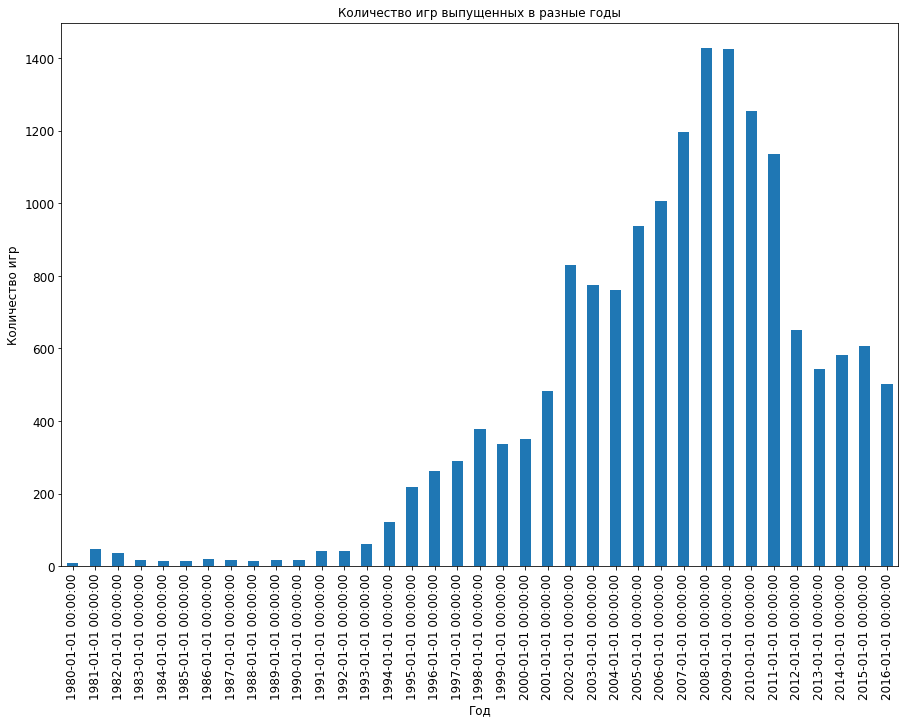

In [24]:
data.groupby('year_of_release')['name'].count().plot(figsize=(15,10),fontsize=12, kind='bar', title='Количество игр выпущенных в разные годы');
plt.xlabel('Год', fontsize=12);
plt.ylabel('Количество игр', fontsize=12);

В "ламповом" 2002 (эх, мафия:)) происходит резкий скачек по выходу игр. Но до этого переода в сумме вышло тоже немало игр.
Просто так отбрасывать валидные данные в исследовании нехорошо. Но если требуется, например, для экономии времени обработки или вычислительных ресурсов рассматривать не весь датасет, то, я бы предположил, что можно рассматривать данные хотя бы с года выпуска PS1 и Win95, следовательно с 95 года. С другой стороны, мы как геймеры, понимаем, что игры забываются быстро, и врядли игры 20 летней давности как то влияют на сегодняшние продажи, если это не культовые старые тайтлы типа GTA. Возможно с этого ракурса есть смысл рассматривать слез последних лет 10...честно говоря вопрос сложный, чтобы ответить на него наверняка, требуется отдельное исследование)

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Для удобства работы создадим второй датасет на базе основного, назовем его data_cut и перенесем в него только 3 столбца 'platform','year_of_release','total_sales'

In [25]:
data_cut = data[['platform','year_of_release','total_sales']]

In [26]:
data_cut.head()

,platform,year_of_release,total_sales
0,Wii,2006-01-01,82.54
1,NES,1985-01-01,40.24
2,Wii,2008-01-01,35.52
3,Wii,2009-01-01,32.77
4,GB,1996-01-01,31.38


Посмотрим сначала как изменялась популярность и доходность всех платформ по годам.

In [27]:
data_pivot = pd.pivot_table(data_cut, index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

In [28]:
data_pivot.head()

year_of_release,1980-01-01,1981-01-01,1982-01-01,1983-01-01,1984-01-01,1985-01-01,1986-01-01,1987-01-01,1988-01-01,1989-01-01,...,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN


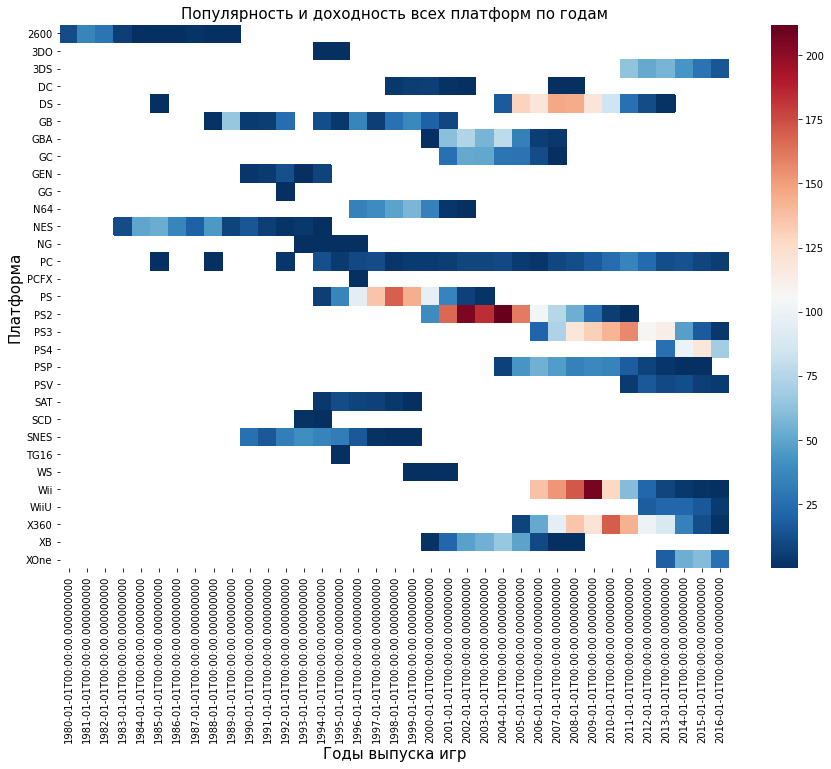

In [29]:
plt.subplots(figsize=(15, 10))
sn.heatmap(data_pivot, cmap='RdBu_r',);
plt.title(label='Популярность и доходность всех платформ по годам', fontsize=15)
plt.xlabel('Годы выпуска игр', fontsize=15);
plt.ylabel('Платформа', fontsize=15);

Построим такой же график для самых популярных платформ по продажам за все время. Сначала посчитаем какие платформы это:

In [30]:
data_all_sales = data_cut.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
data_all_sales

platform
PS2     1255.77
X360     971.42
PS3      939.64
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Как можно заметить, в топе популярных платформ есть такие, время которых ушло, и в последние годы продажи на них отсутствуют. Например PS2 - 1255.77 копий, или Nintendo DS - 806.12 копий.
В задании требуется построить распределение продаж по годам самых прибыльных платформ. Выберем те, продажи которых перешагнули порог в 100млн проданных копий игр.

In [31]:
data_all_sales_over_100 = data_all_sales.loc[data_all_sales > 100]
data_all_sales_over_100

platform
PS2     1255.77
X360     971.42
PS3      939.64
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
Name: total_sales, dtype: float64

Теперь получим список этих платформ, чтобы в датафрейме выбрать необходимые нам строки

In [32]:
index_over_100 = data_all_sales_over_100.index
index_over_100

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC',
       '3DS', 'XB', 'GB', 'NES', 'N64', 'SNES', 'GC', 'XOne'],
      dtype='object', name='platform')

In [33]:
data_cut_over_100 = data_cut.query('platform in @index_over_100')

In [34]:
data_cut_over_100.head()

,platform,year_of_release,total_sales
0,Wii,2006-01-01,82.54
1,NES,1985-01-01,40.24
2,Wii,2008-01-01,35.52
3,Wii,2009-01-01,32.77
4,GB,1996-01-01,31.38


Получили датафрйем с платформами, продажи игр на которых перешагнули порог 100 млн копий
Построим по ним такой же heatmap

In [35]:
data_pivot_over_100 = pd.pivot_table(data_cut_over_100, index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')

In [36]:
data_pivot_over_100.head()

year_of_release,1983-01-01,1984-01-01,1985-01-01,1986-01-01,1987-01-01,1988-01-01,1989-01-01,1990-01-01,1991-01-01,1992-01-01,...,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01
platform,,,,,,,,,,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DS,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GB,NaN,NaN,NaN,NaN,NaN,1.43,64.97,4.89,5.57,25.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


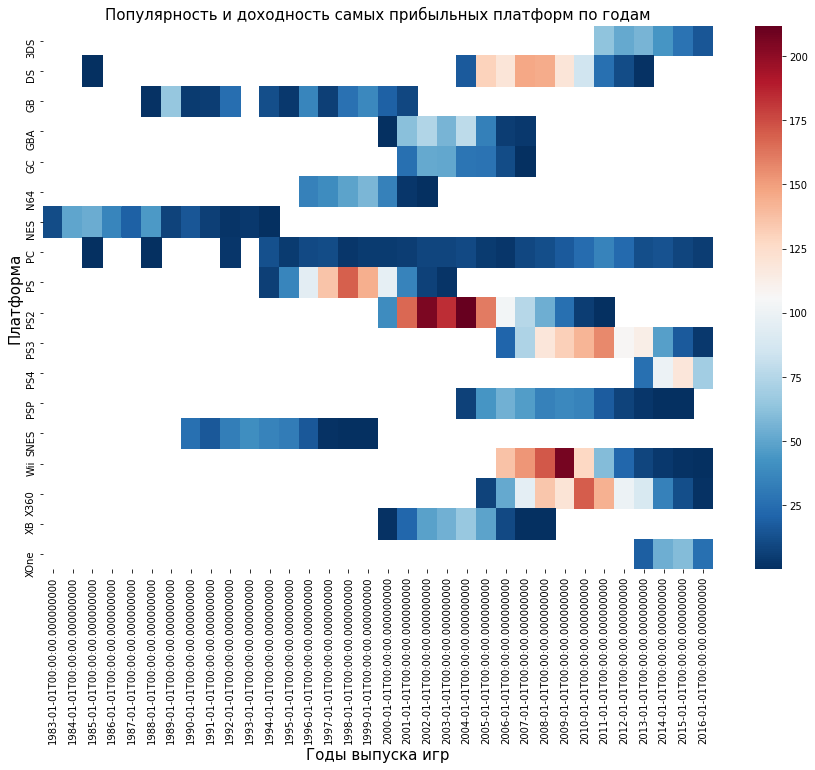

In [37]:
plt.subplots(figsize=(15, 10))
sn.heatmap(data_pivot_over_100, cmap='RdBu_r',);
plt.title(label='Популярность и доходность самых прибыльных платформ по годам', fontsize=15)
plt.xlabel('Годы выпуска игр', fontsize=15);
plt.ylabel('Платформа', fontsize=15);

Найдена еще аномалия в данных по Nintendo DS. В датафрейме есть данные о продажах игр для этой платформы в 1985 году, при том, что платформа вышла в 2004...

Ответить на вопрос "За какой характерный срок появляются новые и исчезают старые платформы?" однозначно нельзя. Слишком большой разрыв между самой долгоиграющей и самой быстро забытой. На это флиет очень много факторов. Популярность платформы, технический прогресс, выпуск консолей конкурентом и т.д.

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы

Поскольку нами прогнозируются продажи на 2017 год, а не глобальная долгосрочная экономоческая стратегия, то можно взять период как актуальный - это последние 5 лет. Так как игровая индустрия очень сильно подтвержена трендам и если в середине 90 были популярны платформеры, в конце 90 -  начале 2000 были популярны стратегии, серидина 2000 - эпоха ММО, то сейчас время Королевских Битв и МOBA, киберспортивных десциплин. Поэтому планировать продажи на 2017, с оглядкой на популярность платформеров или квестов в 90-ых - нецелесообразно. 

Так же не видится целесообразным брать в расчет для прогноза продаж, неактуальные платформы, на которых продажи отсутствуют вприницие с течении нескольких нет. Следовательно мы будем рассматривать переод последних 5 лет и только для платформ, которые показали хоть какие либо продажи в последнем году.

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Так, мы создадим сводную таблицу по всем платформам, которые показали какие либо продажи в последнем году, т.е являются для игроков "актуальными"

In [38]:
data_pivot_alive_platforms = data_pivot.loc[data_pivot['2016-01-01'] >0]
data_pivot_alive_platforms

year_of_release,1980-01-01,1981-01-01,1982-01-01,1983-01-01,1984-01-01,1985-01-01,1986-01-01,1987-01-01,1988-01-01,1989-01-01,...,2007-01-01,2008-01-01,2009-01-01,2010-01-01,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01
platform,,,,,,,,,,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
PC,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,0.03,NaN,...,9.28,12.42,16.91,24.28,35.03,23.22,12.38,13.28,8.52,5.25
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.35,113.25,47.76,16.82,3.60
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25
PSV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.63,16.19,10.59,11.90,6.25,4.25
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
WiiU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.56,21.65,22.03,16.35,4.60
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52
XOne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.96,54.07,60.14,26.15


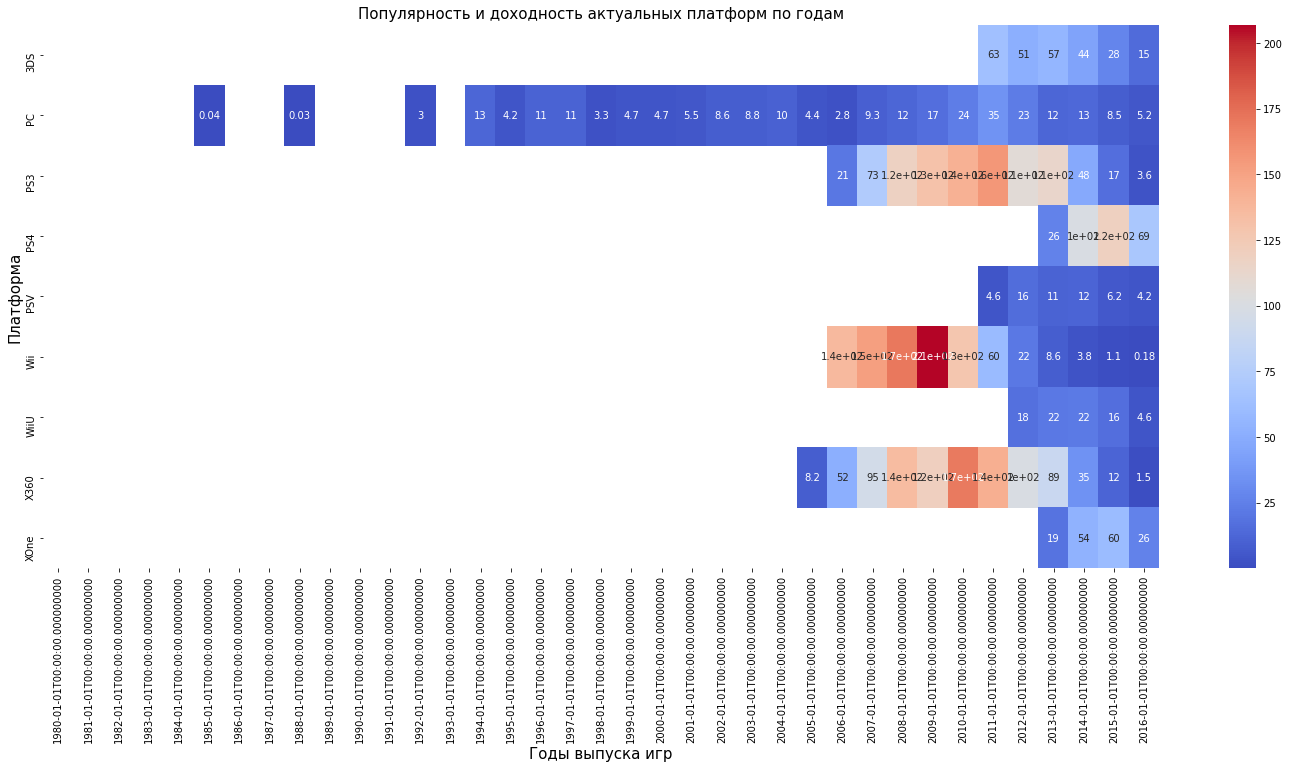

In [39]:
plt.subplots(figsize=(25, 10))
sn.heatmap(data_pivot_alive_platforms, cmap='coolwarm', annot=True);
plt.title(label='Популярность и доходность актуальных платформ по годам', fontsize=15)
plt.xlabel('Годы выпуска игр', fontsize=15);
plt.ylabel('Платформа', fontsize=15);

И постоим такой же график для актуальных платформ за последние 5 лет

Сначала на базе первоначального датасета, создадим новый датасет и сводную таблицу, только для актуальных платформ, которые мы вычислили выше, и только за последние 5 лет.

In [40]:
living_platfoms = data_pivot_alive_platforms.index.to_list() #Получили актуальные платформы в виде списка
living_platfoms #проверили

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

In [41]:
last_5_years = ['2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01'] #создадим список годов, которые нас интересуют
last_5_years

['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01']

In [42]:
#data_alive = data.loc[(data['platform'].isin(living_platfoms))&(data['year_of_release'].isin(last_5_years))]

In [43]:
data_alive = data.loc[data['year_of_release'].isin(last_5_years)]

In [44]:
data_alive

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012-01-01,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014-01-01,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016-01-01,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016-01-01,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


Теперь у нас есть полный датафрейм со всеми данными, но только за последние 5 лет.

Сделаем по нему heatmap, будет как предыдущий, только с зумом на последние 5 лет.

In [45]:
data_alive_pivot = pd.pivot_table(data_alive, index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
data_alive_pivot

year_of_release,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,NaN,NaN,NaN
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.35,113.25,47.76,16.82,3.60
PS4,NaN,25.99,100.00,118.90,69.25
PSP,7.69,3.14,0.24,0.12,NaN
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60


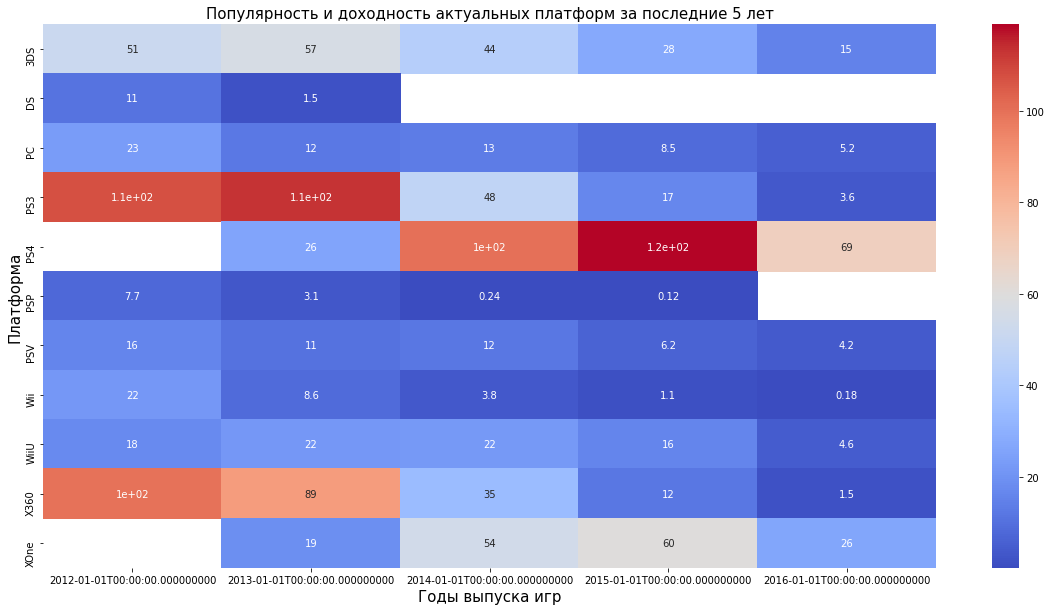

In [46]:
plt.subplots(figsize=(20, 10))
sn.heatmap(data_alive_pivot, cmap='coolwarm', annot=True);
plt.title(label='Популярность и доходность актуальных платформ за последние 5 лет', fontsize=15)
plt.xlabel('Годы выпуска игр', fontsize=15);
plt.ylabel('Платформа', fontsize=15);

Теперь мы сможем ответить на вопрос "Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ"

Как мы видим на графике, на всех актуальных платформах, рассматриваемых выше, продажи падают из года в год. Но есть условные лидеры, продажи которых хоть и упали вместе со всеми, но все равно составляют большие значения. 
Это PS4 - 69 млн копий
XboxOne - 26 млн копий
Nintendo 3DS - 15 млн копий.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [47]:
data_alive.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387161,0.01,0.0400,0.11,0.3125,14.60
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06
PC,250.0,0.250600,0.494640,0.01,0.0300,0.08,0.2400,5.14
PS3,492.0,0.586951,1.464113,0.01,0.0500,0.20,0.6100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
PSP,173.0,0.064682,0.071296,0.01,0.0200,0.03,0.0900,0.36
PSV,411.0,0.119659,0.203011,0.01,0.0200,0.05,0.1200,1.96
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
WiiU,147.0,0.559116,1.058836,0.01,0.0800,0.22,0.5250,7.09


(0.0, 2.0)

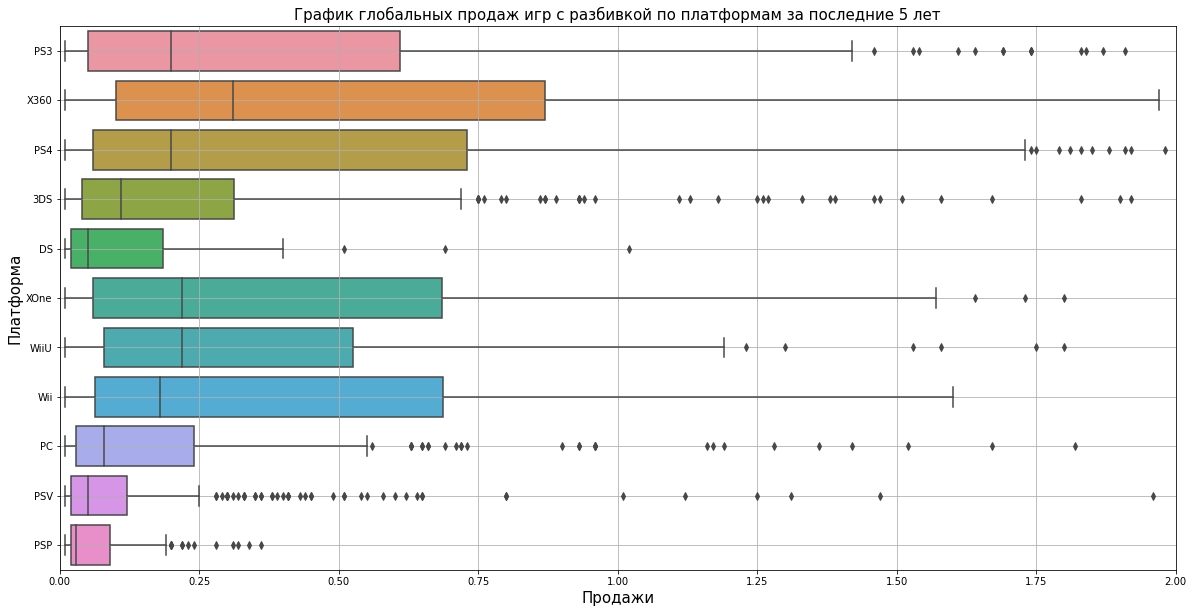

In [48]:
plt.subplots(figsize=(20, 10))
plt.title(label='График глобальных продаж игр с разбивкой по платформам за последние 5 лет', fontsize=15)
sn.set_palette('Set2')
sn.boxplot(
    data=data_alive,
    x='total_sales',
    y='platform',
);
plt.xlabel('Продажи', fontsize=15);
plt.ylabel('Платформа', fontsize=15);
plt.grid(True)
plt.xlim(0,2)

У всех платформ много выбросов, возможно это "хиты". Разные максимумы цены. PS4, Xone WII в общей массе продаж примерно равны. PS5, PC, 3DS сильно отстают от остальных.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Рассмотрим платформу XOne, как одну из популярнейших.

In [49]:
da = data_alive.loc[data_alive['platform']=='XOne']
da['user_score'] = da['user_score'].apply(lambda x: x * 10)

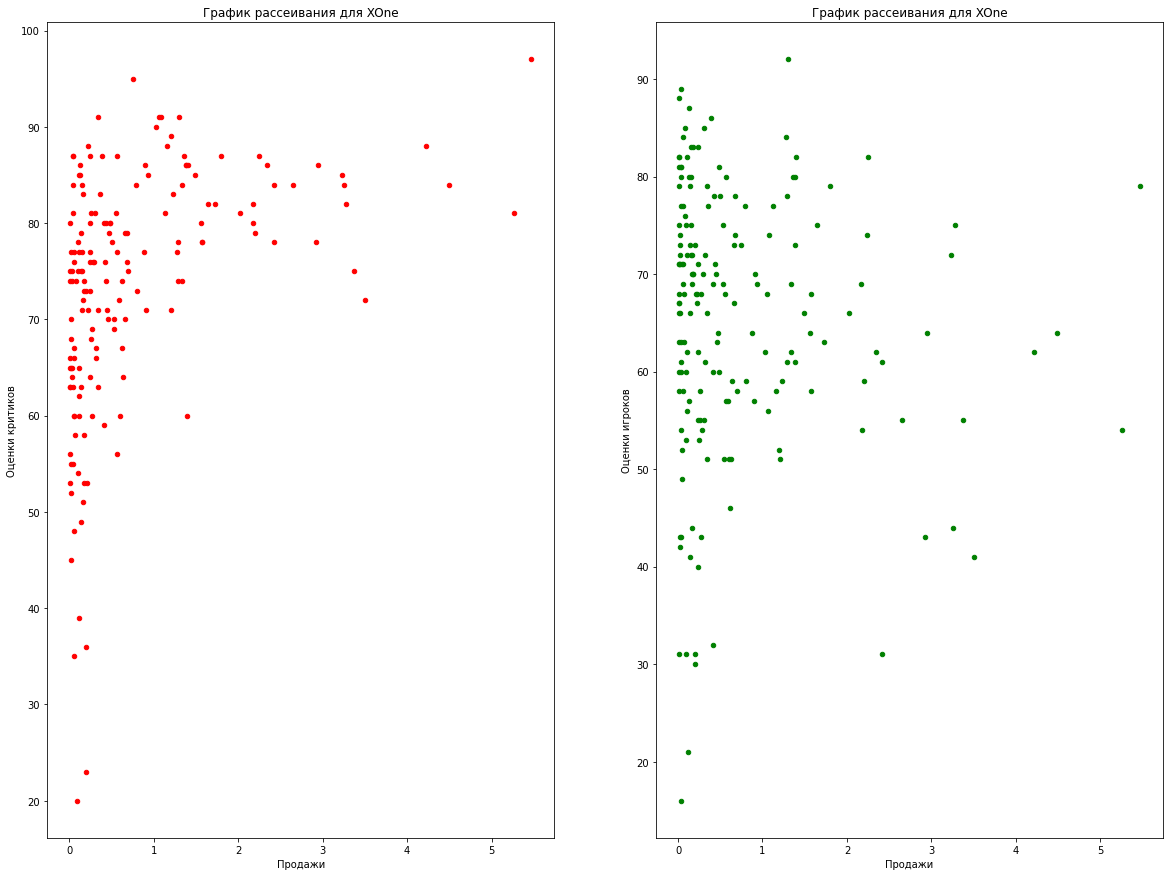

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
da.plot(kind='scatter', x='total_sales', y='critic_score', ax=axs[0], color='red', xlabel='Продажи', ylabel='Оценки критиков', title='График рассеивания для XOne')
da.plot(kind='scatter', x='total_sales', y='user_score', ax=axs[1], color='green', xlabel='Продажи', ylabel='Оценки игроков', title='График рассеивания для XOne')
plt.show()

In [51]:
corr_users = da[['user_score','total_sales']].corr()
corr_users

,user_score,total_sales
user_score,1.000000,-0.068925
total_sales,-0.068925,1.000000


In [52]:
corr_critics = da[['critic_score','total_sales']].corr()
corr_critics

,critic_score,total_sales
critic_score,1.000000,0.416998
total_sales,0.416998,1.000000


По платформе XOne получается любопытное наблюдение, между продажами и оценками критиков наблюдается средняя корреляция. Как будто у покупателей не очень много доверия к критикам.
А вот между оценками игроков и продажами корреляция вообще очень слабо отрицательная.
Тут возможны 2 причины.
1) Все мы ставим отзыв, обычно, на что то плохое)) Намного чаще, чем на хорошее.
2) Возможно просто игрокам больше нравятся маленькие инди-игры, а ежегодные франшизы блокбастеры уже надоели и пользователи оценивают их хуже.

### Соотнесите выводы с продажами игр на других платформах

Сделаем такое же исследование для остальных платформ. У нас уже есть актуальные платформы в виде списка living_platfoms

In [53]:
living_platfoms

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

In [54]:
living_platfoms_no_xbox = living_platfoms[:] #Сделаем второй экземпляр списка акутальных платформ, чтобы оставить оригинальный целым

In [55]:
living_platfoms_no_xbox.remove('XOne')
living_platfoms_no_xbox

['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360']

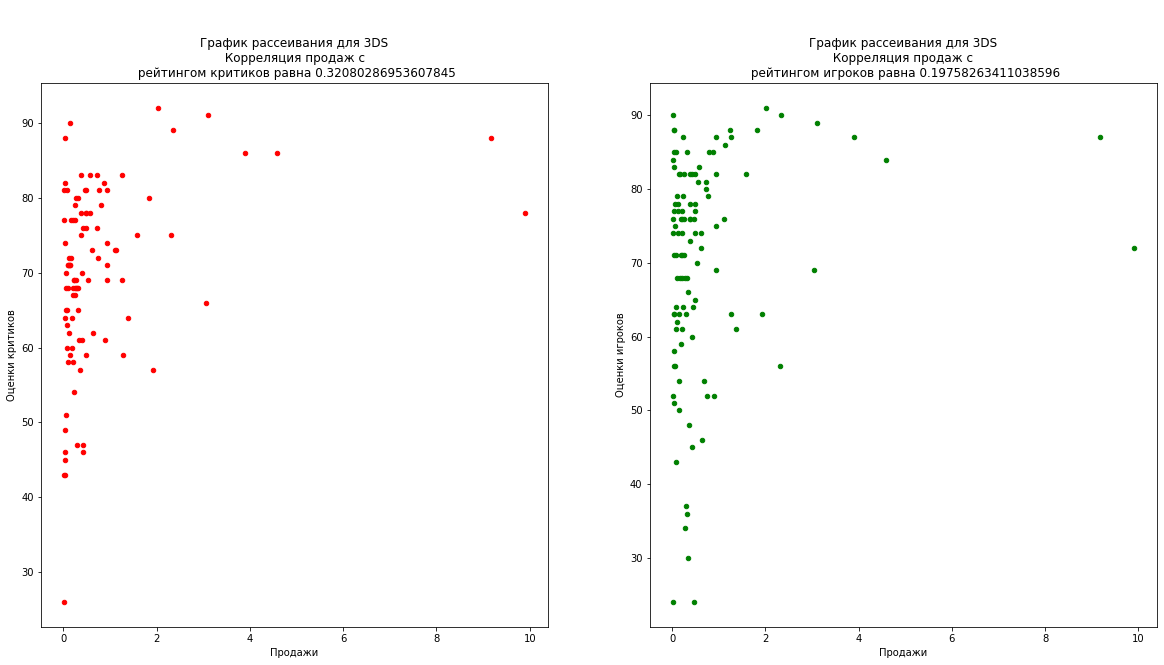

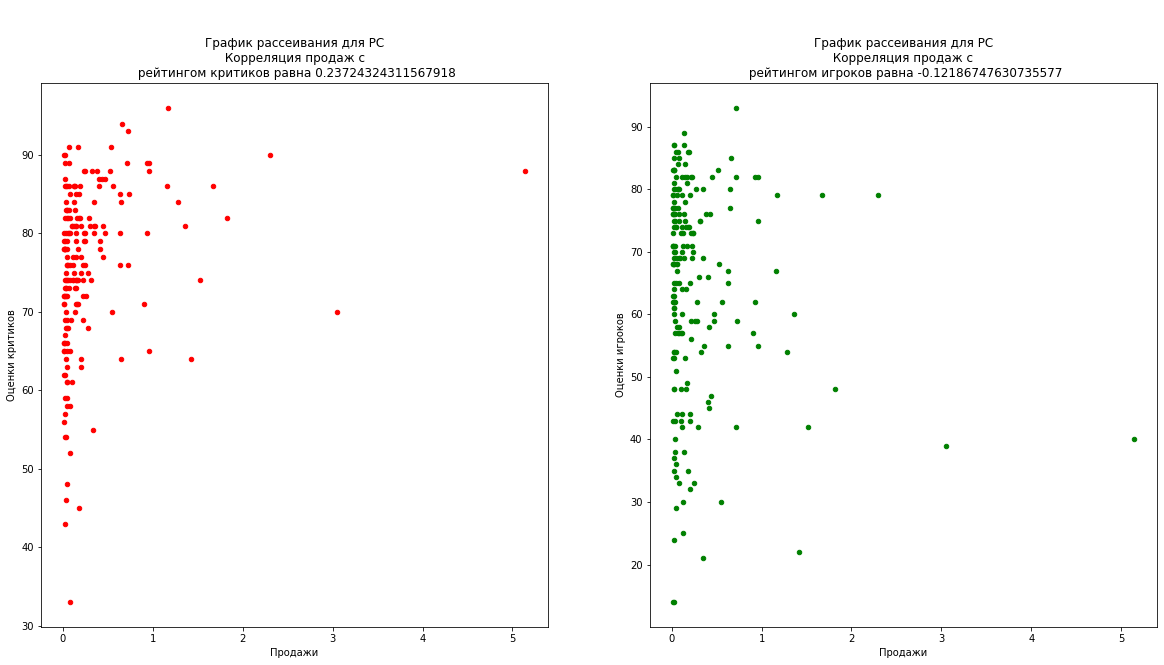

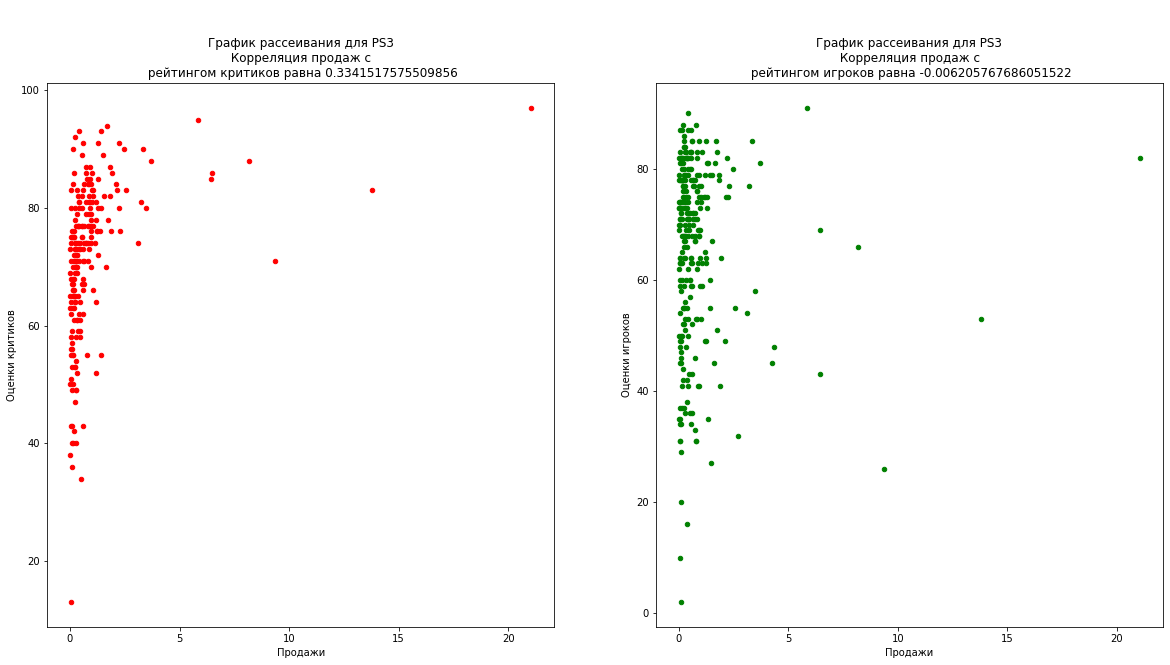

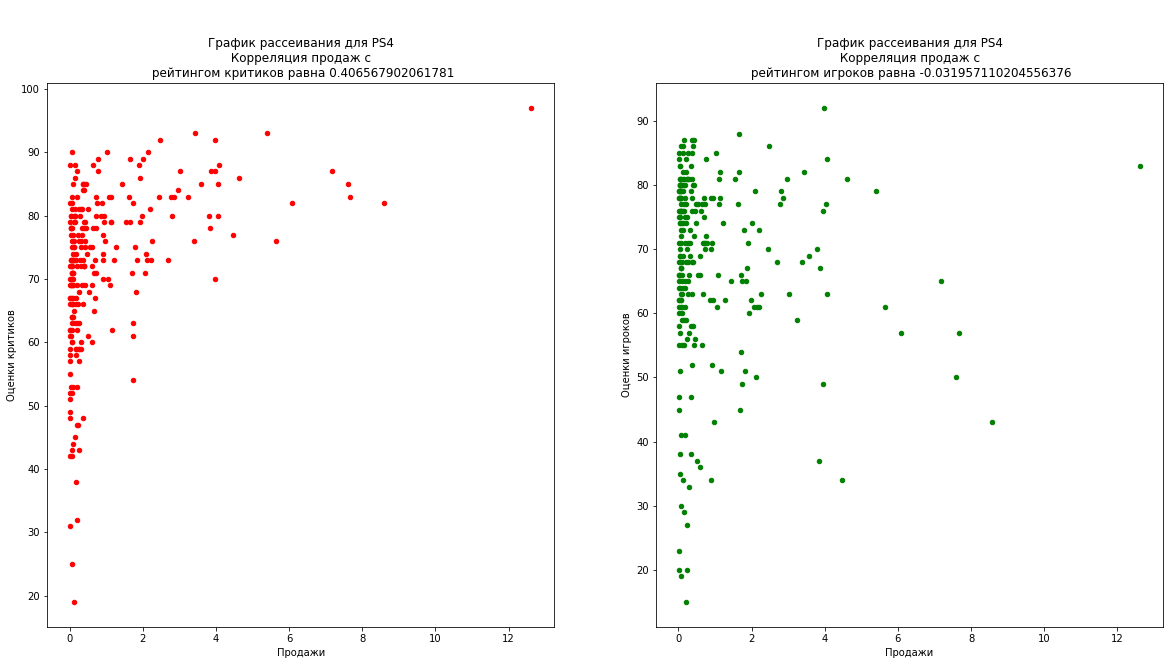

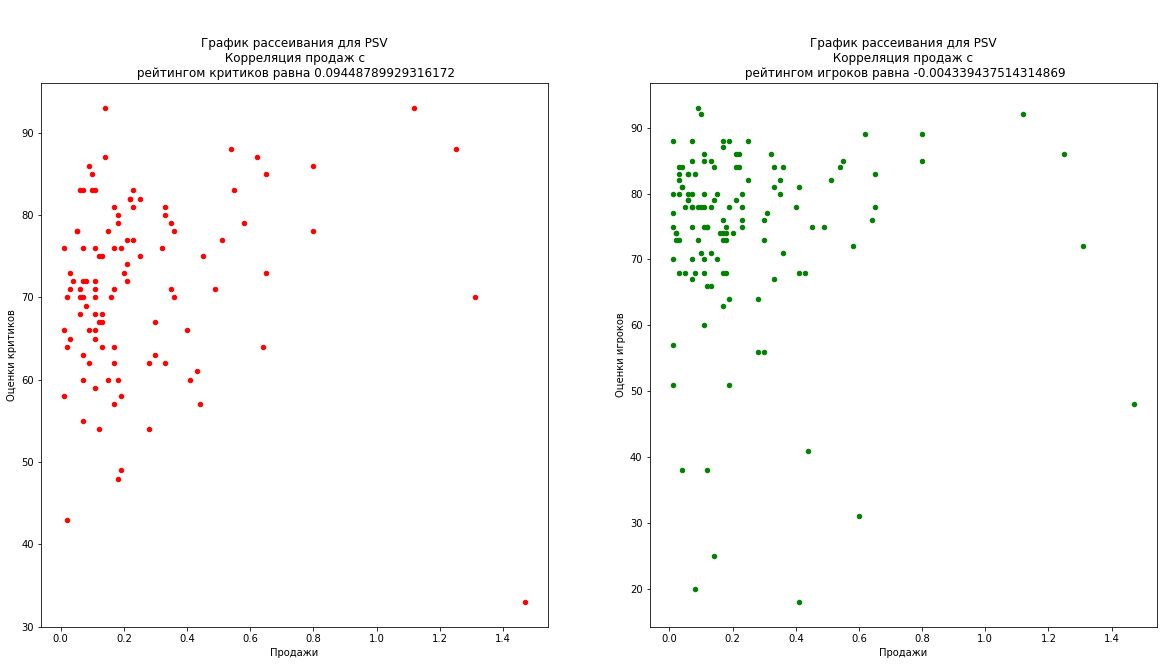

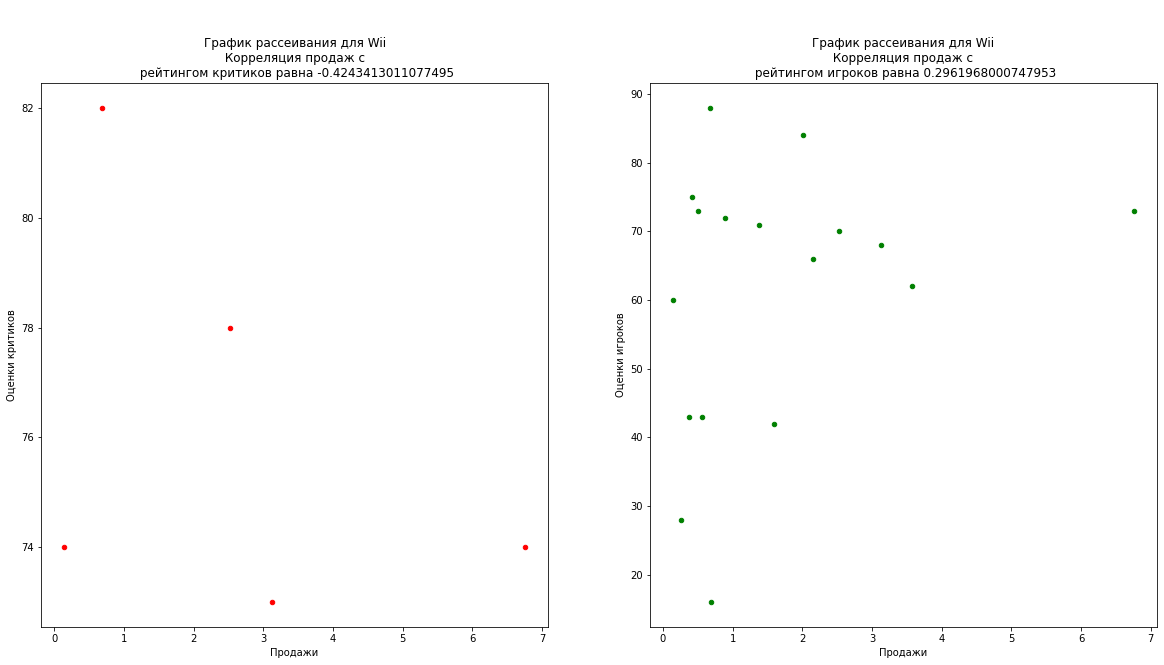

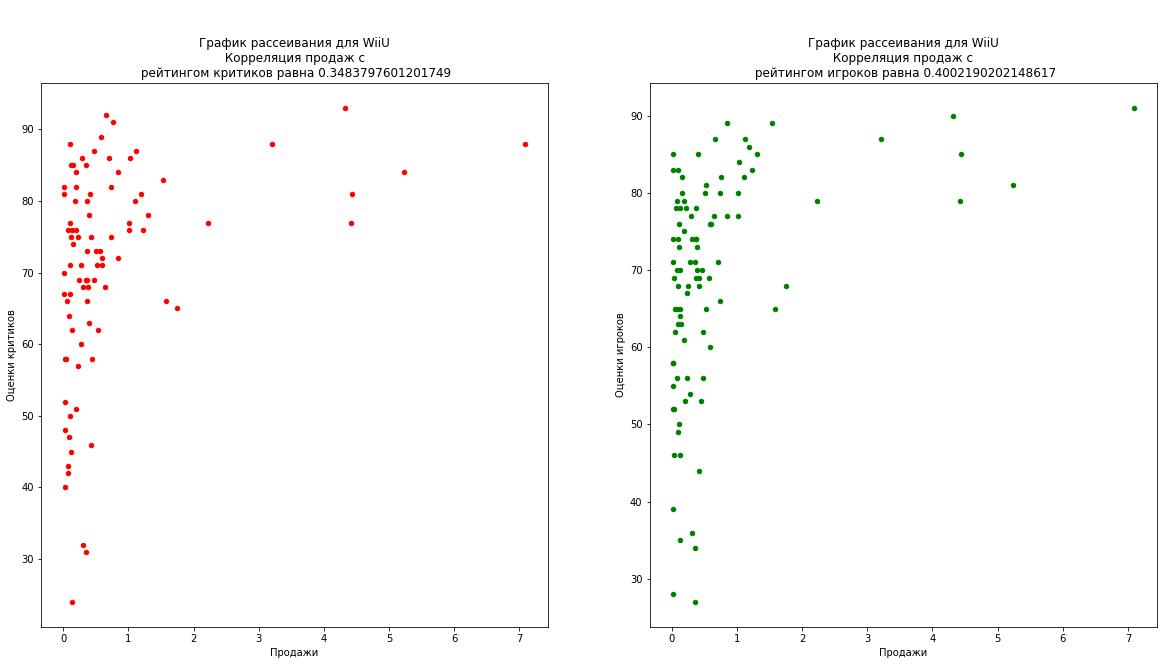

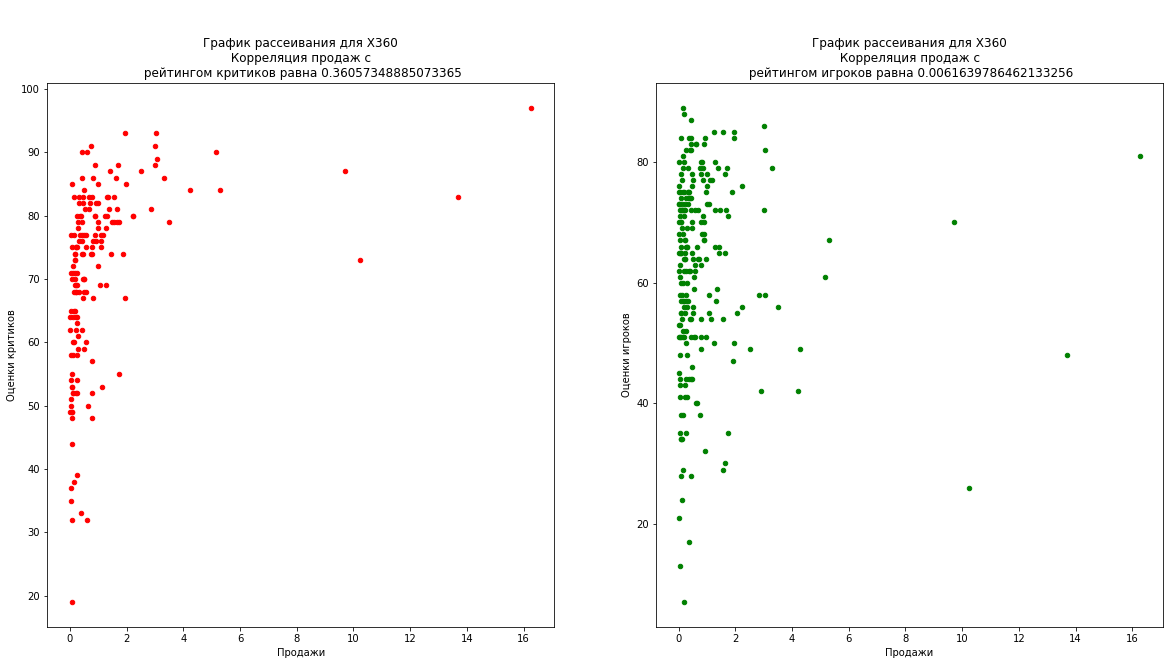

In [56]:
for platforma in living_platfoms_no_xbox:
    current_platform = data_alive.loc[data_alive['platform']==platforma]
    corr_users = current_platform['total_sales'].corr(current_platform['user_score'])
    corr_critic = current_platform['total_sales'].corr(current_platform['critic_score'])
    current_platform['user_score'] = current_platform['user_score'].apply(lambda x: x * 10)
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    current_platform.plot(kind='scatter', x='total_sales', y='critic_score', ax=axs[0], color='red', xlabel='Продажи', ylabel= 'Оценки критиков', title=f'\n\nГрафик рассеивания для {platforma}\n Корреляция продаж с \n рейтингом критиков равна {corr_critic}')
    current_platform.plot(kind='scatter', x='total_sales', y='user_score', ax=axs[1], color='green', xlabel='Продажи', ylabel= 'Оценки игроков', title=f'\n\nГрафик рассеивания для {platforma}\n Корреляция продаж с \n рейтингом игроков равна {corr_users}')
    plt.show()

Все платформы обьединяет факт, что оценки игроков коррелируют с продажами крайне слабо, другое дело оценки критиков, там корреляция средней силы.
Выделяется на фоне остальных только WiiU, там корреляция между продажами и оценками игроков, наоборот, сильнее, чем с оценками критиков. У пользователей Nintendo всегда свой путь.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

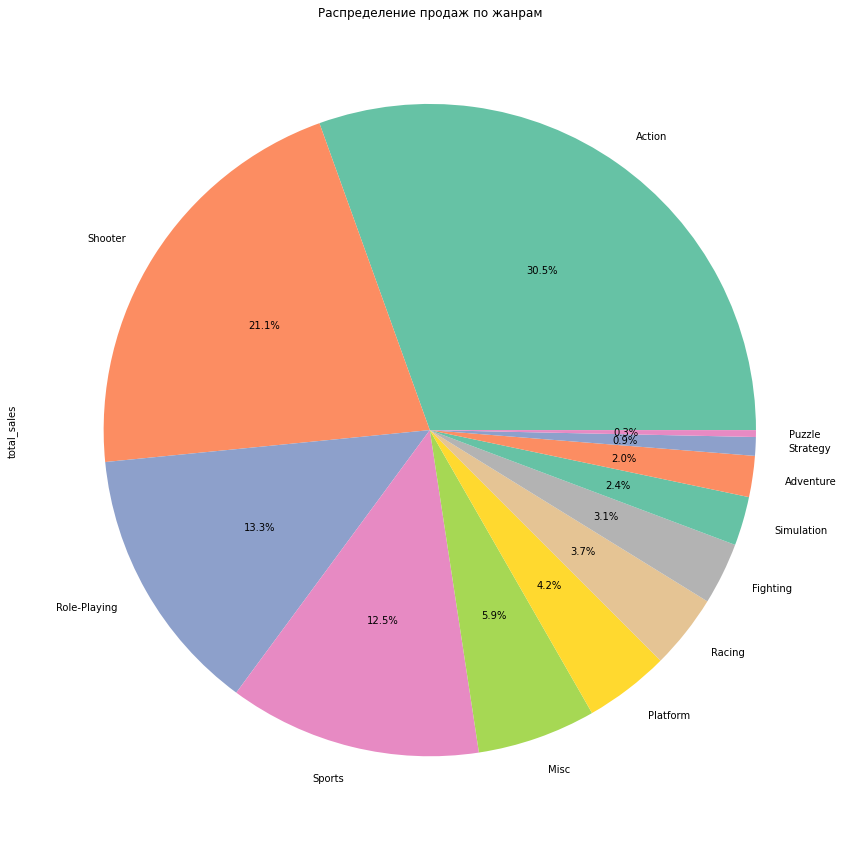

In [57]:
data_alive.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(15,15), title='Распределение продаж по жанрам');

Самый популярный жанр Action - 30.5% продаж
Следом идет Shooter - 21.1% продаж
RPG и Sports 13.3% и 12.5% соответственно.

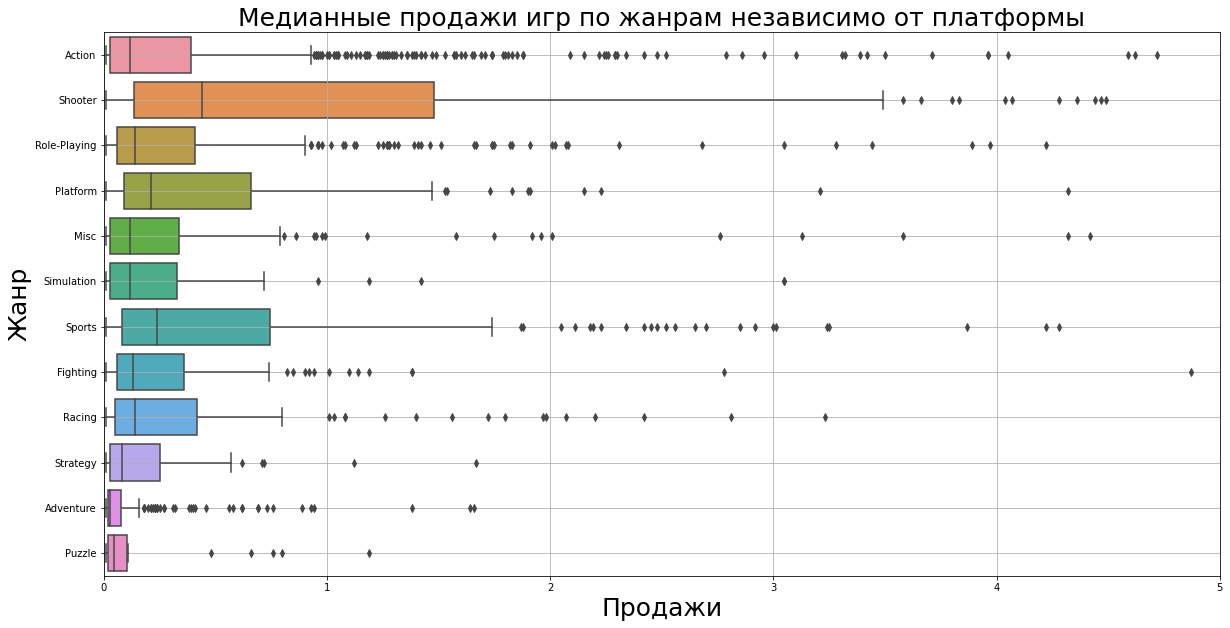

In [58]:
plt.subplots(figsize=(20, 10))
plt.title(label='Медианные продажи игр по жанрам независимо от платформы', fontsize=25)
sn.set_palette('Set2')
sn.boxplot(
    data=data_alive,
    x='total_sales',
    y='genre',
);
plt.xlabel('Продажи', fontsize=25);
plt.ylabel('Жанр', fontsize=25);
plt.grid(True)
plt.xlim(0,5);

In [59]:
data_alive.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,1031.0,0.427856,1.166504,0.01,0.030,0.120,0.3900,21.05
Adventure,302.0,0.097450,0.208237,0.01,0.020,0.030,0.0775,1.66
Fighting,109.0,0.408165,0.910385,0.01,0.060,0.130,0.3600,7.55
Misc,192.0,0.442917,1.081047,0.01,0.030,0.120,0.3375,9.18
Platform,85.0,0.717647,1.364413,0.01,0.090,0.210,0.6600,9.90
Puzzle,28.0,0.174643,0.305438,0.01,0.020,0.045,0.1025,1.19
Racing,115.0,0.465217,0.888664,0.01,0.050,0.140,0.4200,7.09
Role-Playing,370.0,0.521081,1.315937,0.01,0.060,0.140,0.4075,14.60
Shooter,235.0,1.296723,2.251662,0.01,0.135,0.440,1.4800,14.63


Промежуточный вывод по популярным жанрам такой, что хоть игры в жанре Экшн показали суммарно самые высокие продажи, тем не менее, игры в жанре Шутер показали более устойчивые продажи вне зависимости от платформы.

##  Составьте портрет пользователя каждого региона

### Определите для пользователя каждого региона (NA, EU, JP):

#### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

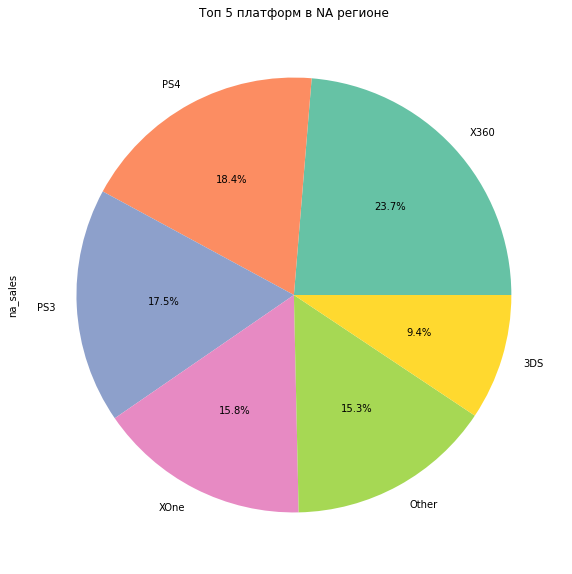

In [60]:
na_platform_pie = data_alive.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
data_alive['na_platform'] = data_alive['platform'].apply(lambda x : x if x in na_platform_pie[0:5] else 'Other')
data_alive.groupby('na_platform')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(10,10), title='Топ 5 платформ в NA регионе');

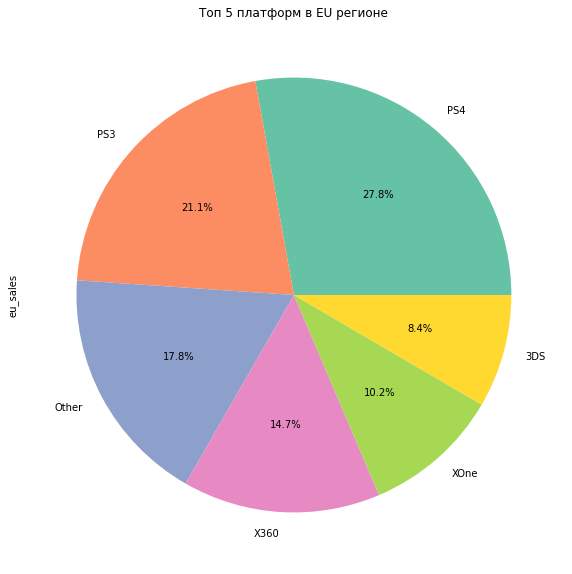

In [61]:
eu_platform_pie = data_alive.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
data_alive['eu_platform'] = data_alive['platform'].apply(lambda x : x if x in eu_platform_pie[0:5] else 'Other')
data_alive.groupby('eu_platform')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(10,10), title='Топ 5 платформ в EU регионе');

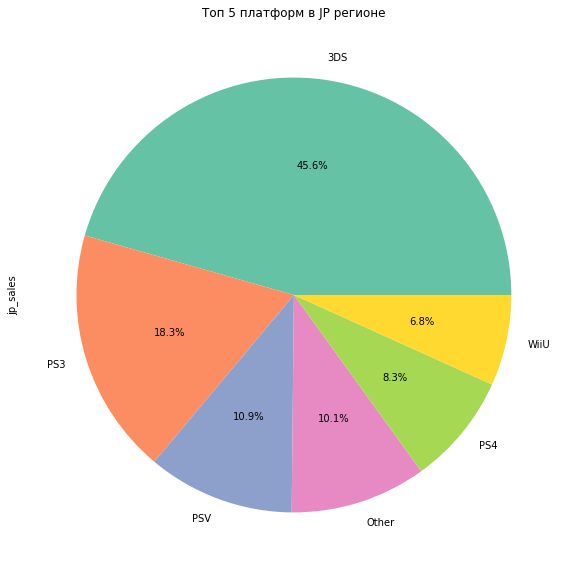

In [62]:
jp_platform_pie = data_alive.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
data_alive['jp_platform'] = data_alive['platform'].apply(lambda x : x if x in jp_platform_pie[0:5] else 'Other')
data_alive.groupby('jp_platform')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(10,10), title='Топ 5 платформ в JP регионе');

В северо-амеркианской регионе топ 5 платформ выглядит так:
* X360 23.7%
* PS4 18.4%
* PS3 17.5%
* XOne 15.8%
* 3DS 9.4%

В европейском регионе топ 5 платформ выглядит так:
* PS4 27.8%
* PS3 21.1%
* X360 14.7%
* XOne 10.2%
* 3DS 8.4%

В японском регионе топ 5 платформ выглядит так:
* 3DS 45.6%
* PS3 18.3%
* PS5 10.9%
* PS4 8.3%
* WiiU 6.8%

В североамериканском регионе и европейском лидируют "большие" консоли, в Японском РАЗИТЕЛЬНОЕ отличие. Почти половина рынка это портативка от Нинтендо. И на 3 месте появилась PS5.

#### Самые популярные жанры (топ-5). Поясните разницу.

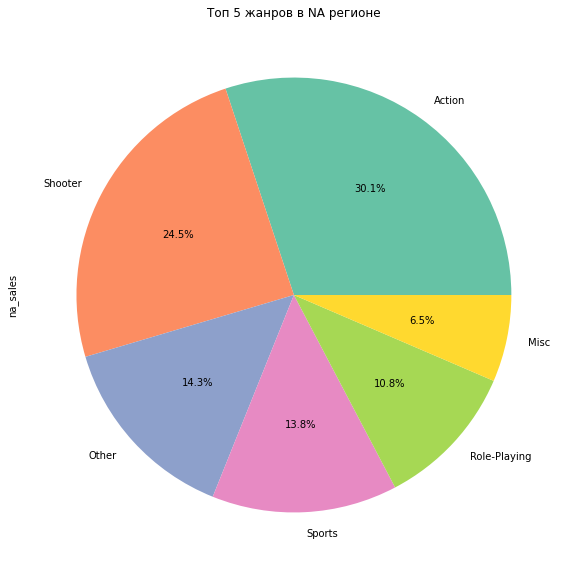

In [63]:
na_genre_pie = data_alive.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
data_alive['na_genre'] = data_alive['genre'].apply(lambda x : x if x in na_genre_pie[0:5] else 'Other')
data_alive.groupby('na_genre')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(10,10),title='Топ 5 жанров в NA регионе');

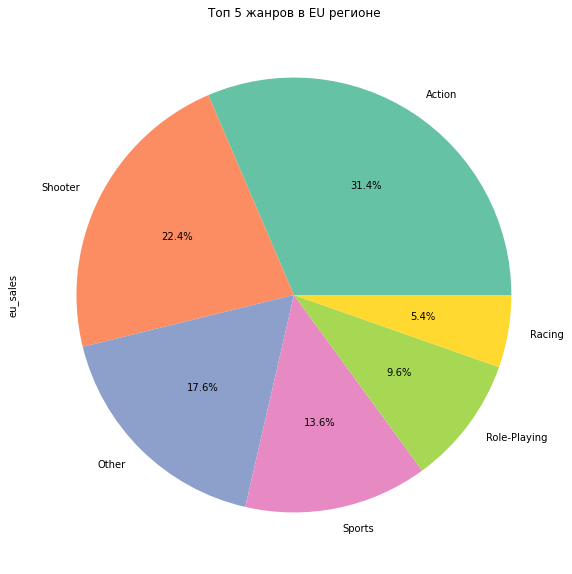

In [64]:
eu_genre_pie = data_alive.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)
data_alive['eu_genre'] = data_alive['genre'].apply(lambda x : x if x in eu_genre_pie[0:5] else 'Other')
data_alive.groupby('eu_genre')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(10,10), title='Топ 5 жанров в EU регионе');

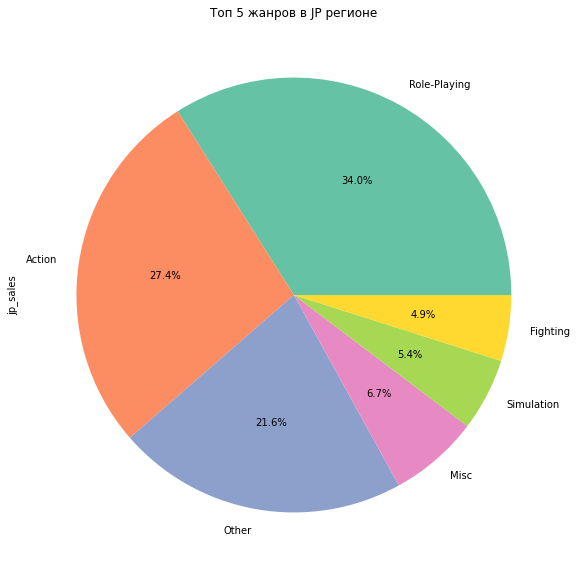

In [65]:
jp_genre_pie = data_alive.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)
data_alive['jp_genre'] = data_alive['genre'].apply(lambda x : x if x in jp_genre_pie[0:5] else 'Other')
data_alive.groupby('jp_genre')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie',autopct='%1.1f%%', figsize=(10,10), title='Топ 5 жанров в JP регионе');

В северо-амеркианской регионе топ 5 жанров выглядит так:
* Action 30.1% 
* Shooter 24.5% 
* Sport 13.8% 
* RPG 10.8% 
* Misc 6.5% 

В европейском регионе топ 5 жанров:
* Action 31.4%
* Shooter 22.4%
* Sport 13.6%
* RPG 9.6%
* Racing 5.4%

В японском регионе:

* RPG 34%
* Action 27.4%
* Misc 6.7%
* Simulation 5.4%
* Fighing 4.9%

Можно заметить, что NA и  EU регионы имеют в топ 5 одни и теже жанры, в очень похожих пропорциях популярности, а предпочтения в JP регионе абсолютно другие. 

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [66]:
data_alive['na_sales'].sum()

590.97

In [67]:
data_alive['eu_sales'].sum()

506.81000000000006

In [68]:
data_alive['jp_sales'].sum()

192.58

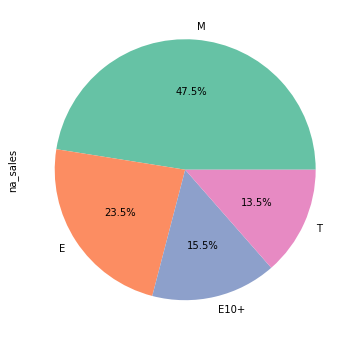

In [69]:
data_alive.groupby('rating')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(6,6));

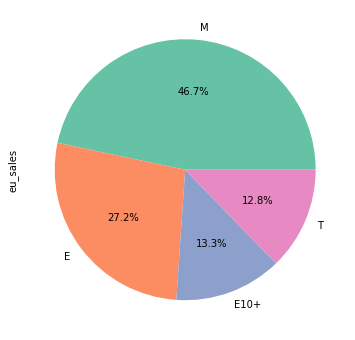

In [70]:
data_alive.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(6,6));

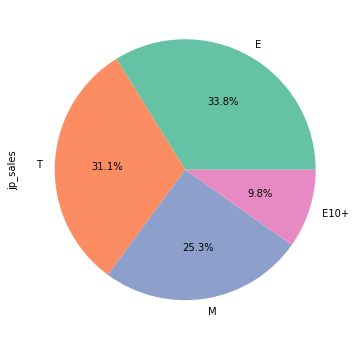

In [71]:
data_alive.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', figsize=(6,6));

Тяжело сказать насколько влияет возрастной рейтинг на продажи игр.
С одной стороны рынок NA и EU имеют самые большие продажи 586.25 и 502.87 млн соответственно, и в этих регионах преобладают по продажам игры с рейтингом M (Mature - самый взрослый рейтинг), но у этих регионов и свои популярные жанры Экшн и Шутер. Особенно Шутер, присвоение им такого рейтинга не вызывает вопросов.

В JP регионе продажи ниже 178.39 млн копий, и большая часть игр имеют рейтинг E (для всех) и Т (для подростков), но в JP и непопулярны шутеры, а преобладают РПГ.

Такой рейтинг скорее не на продажи влият, а просто характеризует игровые предпочтения.

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Формулируем гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - это будет нулевой гепотезой. Альтернативную не ставим, т.к. будем проверять двустороннюю гипотезу.

In [72]:
sample_xbox = data_alive.loc[data_alive['platform']=='XOne','user_score'].dropna()
sample_pc = data_alive.loc[data_alive['platform']=='PC','user_score'].dropna()

alpha = 0.05

result = st.ttest_ind(sample_xbox, sample_pc, equal_var=False)
print('p-value:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.5489537965134912
Нет оснований отвергнуть нулевую гипотезу


p-value оказалось выше установленного нами минимального порога значимости, значит нулевая гипотеза не опровергается. Следовательно мы не может опровергнуть утверждение, что "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверяет гипотезу : "Средние пользовательские рейтинги жанров Action и Sports разные"
Т.к. статистический тест проверяет выборки на равность, то нулевую гипотезу мы будем формулировать зеркально. 
Формулируем нулевую гипотезу: "Средние пользовательские рейтинги жанров Action и Sports РАВНЫ". Если нулевая гепотеза будет опровергнута, значит этим мы подтвердим предположение что "Средние пользовательские рейтинги жанров Action и Sports РАЗНЫЕ"
Иными словами, "Средние пользовательские рейтинги жанров Action и Sports РАЗНЫЕ" - будет нашей альтернативной гипотезой припроверке двусторонней нулевой гипоетзы.

In [73]:
sample_action = data_alive.loc[data_alive['genre']=='Action','user_score'].dropna()
sample_sport = data_alive.loc[data_alive['genre']=='Sports','user_score'].dropna()

alpha = 0.05

result = st.ttest_ind(sample_action, sample_sport, equal_var=False)
print('p-value:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 5.989458066467418e-20
Отвергаем нулевую гипотезу


p-value сильно ниже, установленного нами минимального порога значимости, следовательно мы отвергаем нашу нулевую гипотезу, и этим подтверждаем гипотезу, что Средние пользовательские рейтинги жанров Action и Sports РАЗЫНЕ.

### Как вы сформулировали нулевую и альтернативную гипотезы

Описано выше.

### Какой критерий применили для проверки гипотез и почему.

Так же логика формулирования гипотез была описана выше.

## Напишите общий вывод

Мы провели исследование данных о продаже игр наразных платформах и регионах с 1980 по 2016 год, для составления рекомендаций на 2017 год. В датасете следующие колонки ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating', 'total_sales'] и 16715 записей строк. Были найдены явные и неявные дубликаты, которые были удалены. Так же были удалены пропуски, в строках с которыми не было информации требуемой для анализа. Все еще остались пропуски в столбцах year_of_release, critic_score, user_score, rating, которые могли быть вызваны разными причинами, описанными выше в иследовании. Был добавлен столбец с данными о сумарных продажах во всех регионах.
В столбце были строковые значения tbd. Это абривиатура To Be Determined, т.е оценка еще не определена, по сути это NaN. Только из-за того, что tbd - строчное значение, весь столбец записан в формате object. Для возможности математических манипуляций со столбцом, мы меняем tbd на значение NaN, что является его эквивалентом.

Мы брали в расчет приверженность игровой индустрии трендам и часто изменении игровых фаворитов рассматривали только последние 5 лет продаж.
Общая тенденция продаж по рассматриваемым платформам негативная. Общие продажи падают из года в год, но есть несколько платформ, продажи которых, тем не менее, имеют существенный обьем и превосходят конкурентов, на этих платформах и рекомендовано сконцентрироваться в 2017 году. Это PS4 - 69 млн копий XboxOne - 26 млн копий Nintendo 3DS - 15 млн копий.

Так же проведено исследование влияния оценок пользователей и критиков на продажи игр. Было обнаружено следующее: Все платформы обьединяет факт, что оценки игроков коррелируют с продажами крайне слабо, другое дело оценки критиков, там корреляция средней силы. Тут возможны 2 причины.
* Все мы ставим отзыв, обычно, на что то плохое)) Намного чаще, чем на хорошее.
* Возможно просто игрокам больше нравятся маленькие инди-игры, а ежегодные франшизы блокбастеры уже надоели и пользователи оценивают их хуже.

Выделяется на фоне остальных только WiiU, там корреляция между продажами и оценками игроков, наоборот, сильнее, чем с оценками критиков. У пользователей Nintendo всегда свой путь.

Помимо того, составлен примерный портрет игрока для каждого региона по их предпочтениям в платформах и жанрах.
Выяснено, что портрет игрока из NA региона схож с портретом игрка из EU региона, как в предпочитаемых платформах, так и в предпочитаемых жанрах.

В северо-амеркианской регионе топ 5 платформ выглядит так:

* X360 23.7%
* PS4 18.4%
* PS3 17.5%
* XOne 15.8%
* 3DS 9.4%

В европейском регионе топ 5 платформ выглядит так:

* PS4 27.8%
* PS3 21.1%
* X360 14.7%
* XOne 10.2%
* 3DS 8.4%

В северо-амеркианской регионе топ 5 жанров выглядит так:

* Action 30.1% 
* Shooter 24.5% 
* Sport 13.8% 
* RPG 10.8% 
* Misc 6.5% 

В европейском регионе топ 5 жанров:

* Action 31.4%
* Shooter 22.4%
* Sport 13.6%
* RPG 9.6%
* Racing 5.4%

NA и EU предпочитают большие домашние консоли, на которых они играют в Action и Shooter'ы.

Портрет игркоа японского региона отличается от предыдущих ОЧЕНЬ сильно. Как в предпочитаемых консолях, так и жанрах.

В японском регионе топ 5 платформ выглядит так:

* 3DS 45.6%
* PS3 18.3%
* PS5 10.9%
* PS4 8.3%
* WiiU 6.8%

В японском регионе:

* RPG 34%
* Action 27.4%
* Misc 6.7%
* Simulation 5.4%
* Fighing 4.9%

Видим, что в японском регионе половина рынка занята портативкой от Нинтендо. Так же и по жанрам. Популярный у европейцев и американцев жанр шутеров не входит в топ 5 продаж. А в топе RPG.

Помимо того были проверены 2 гипотезы.
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Эту мы подтвердили эту гипотезу. Ничего удивительного, тем более, что это в каком то смысле "родные" платформы. На Xbox нет эксклюзивов + наличие GamePass на обоих платформах.

* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Эту гипотезу мы рассматривали как альтернативную для зеркальной. И она (альтернативная) была подтверждена. Средние оценки действительно разные.

Были изучены суммарные продажи игр в регионах (размер рынков), а так же медианные продажи жанров вне зависимости от платформы.
* Общие продажи в NA регионе 590.97 млн копий
* Общие продажи в EU регионе 506.81 млн копий
* Общие продажи в JP регионе 192.58 млн копий

Изучение медианных продаж вне зависимости от платформы показало, что хоть жанр Экшн и продался в сумме большим количеством копий, но жанр Шутеров намного опережает его по медианным продажам.

По итогу, можно рекомендовать магазину сосредоточиться на продаже игр, нацеленных  на NA и EU регионы, как самые крупные рынки.
Сосредоточиться на платформах X360,PS3,PS4 как самых популярных в этих регионах и сделать акцент на играх в жанре Экшн, Шутер, и Спорт как самых популярных жанрах. Особенно в жанре Шутер. Он не показал таких больших итоговых продаж как Экшн, но демонстрирует сильную выдержку и продажи вне зависимости от платформы, что может гарантировать хорошую отдачу.